                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4858      0.020     24.114      0.000       0.446       0.525
ma.L1         -0.9637      0.007   -136.850      0.000      -0.978      -0.950
ar.S.L12      -0.5192      0.019    -26.735      0.000      -0.557      -0.481
sigma2        33.9281      1.011     33.557      0.000      31.946      35.910


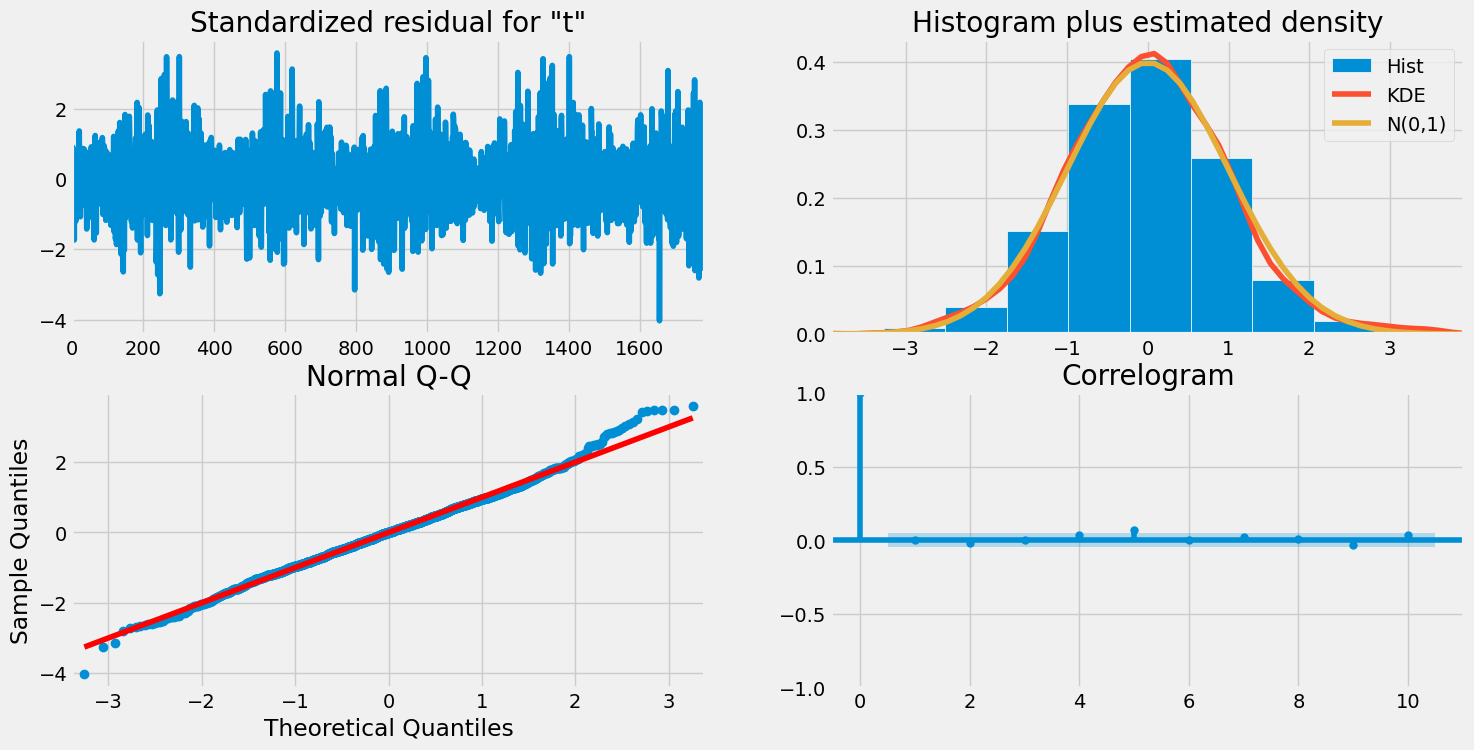

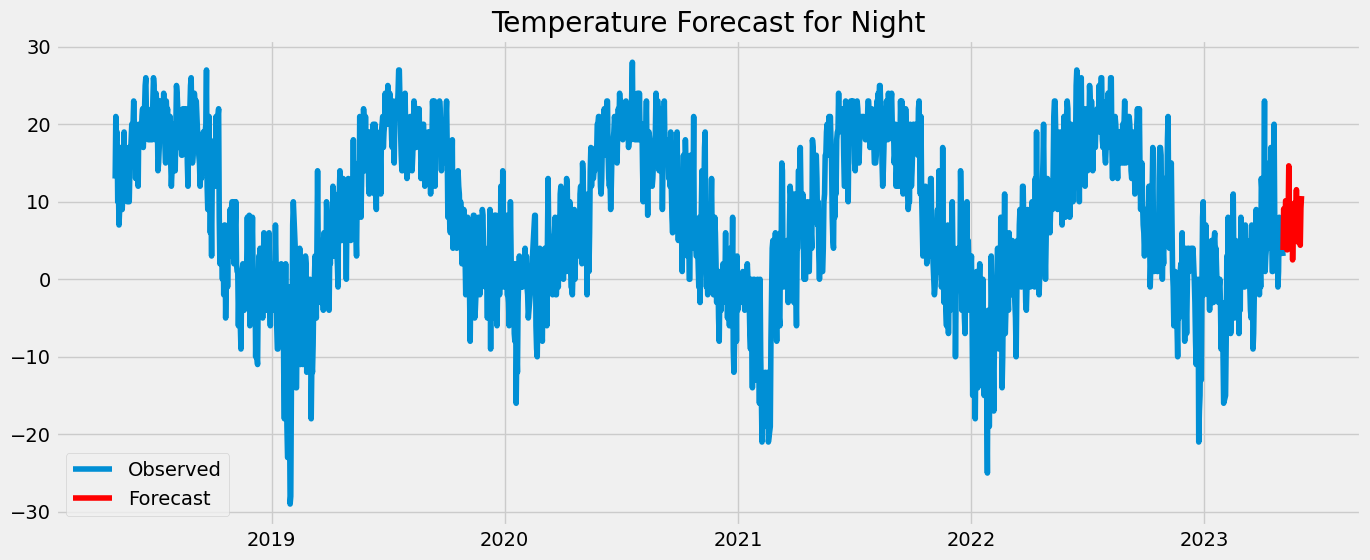

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5957      0.020     30.405      0.000       0.557       0.634
ma.L1         -0.9639      0.007   -141.135      0.000      -0.977      -0.950
ar.S.L12      -0.5243      0.019    -27.260      0.000      -0.562      -0.487
sigma2        29.1412      0.824     35.345      0.000      27.525      30.757


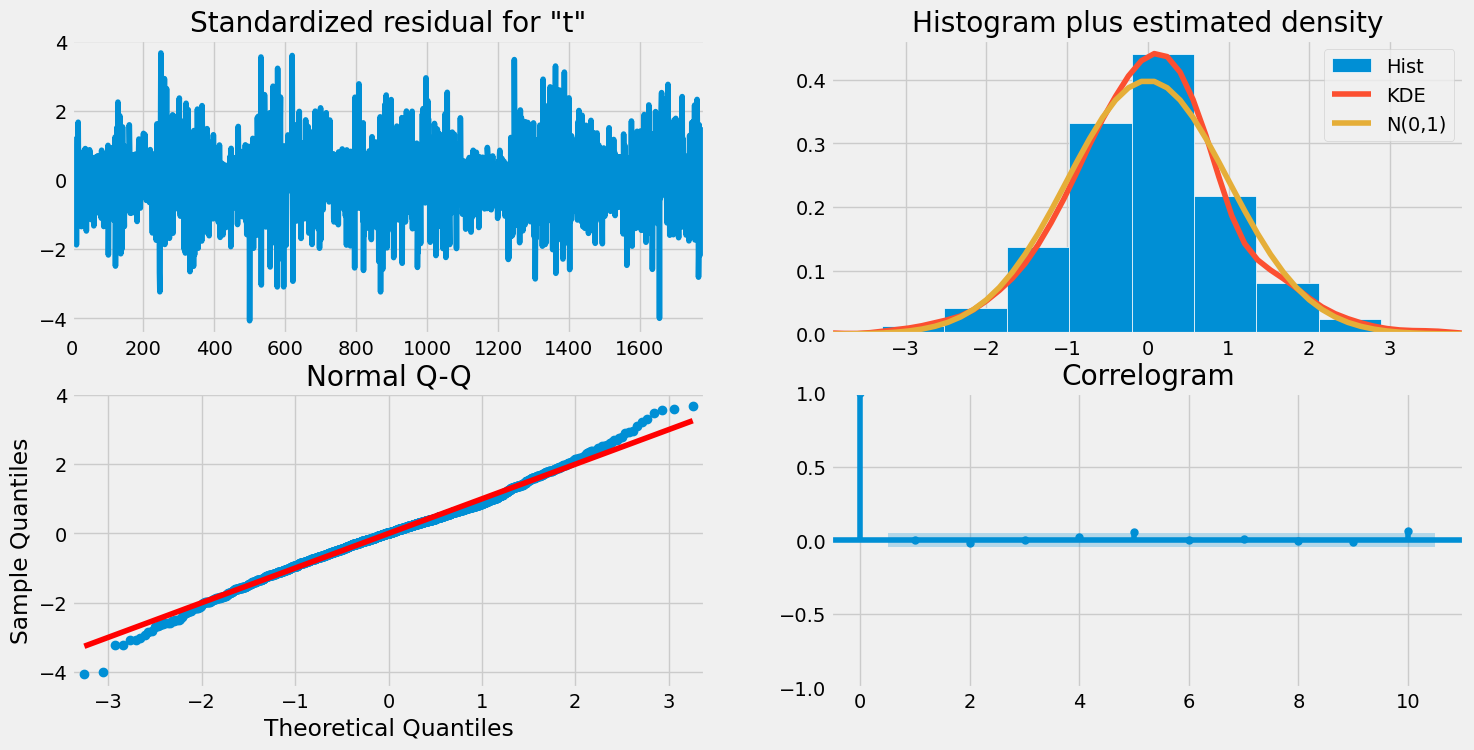

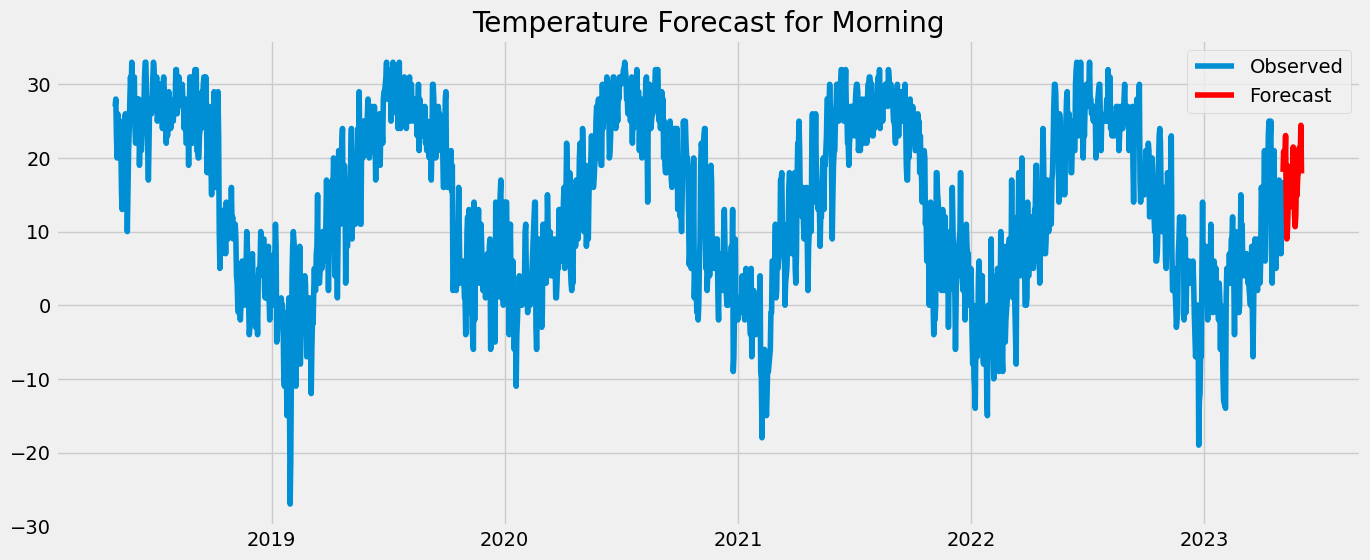

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5573      0.021     26.964      0.000       0.517       0.598
ma.L1         -0.9586      0.007   -130.633      0.000      -0.973      -0.944
ar.S.L12      -0.5276      0.019    -27.336      0.000      -0.565      -0.490
sigma2        31.4405      0.935     33.629      0.000      29.608      33.273


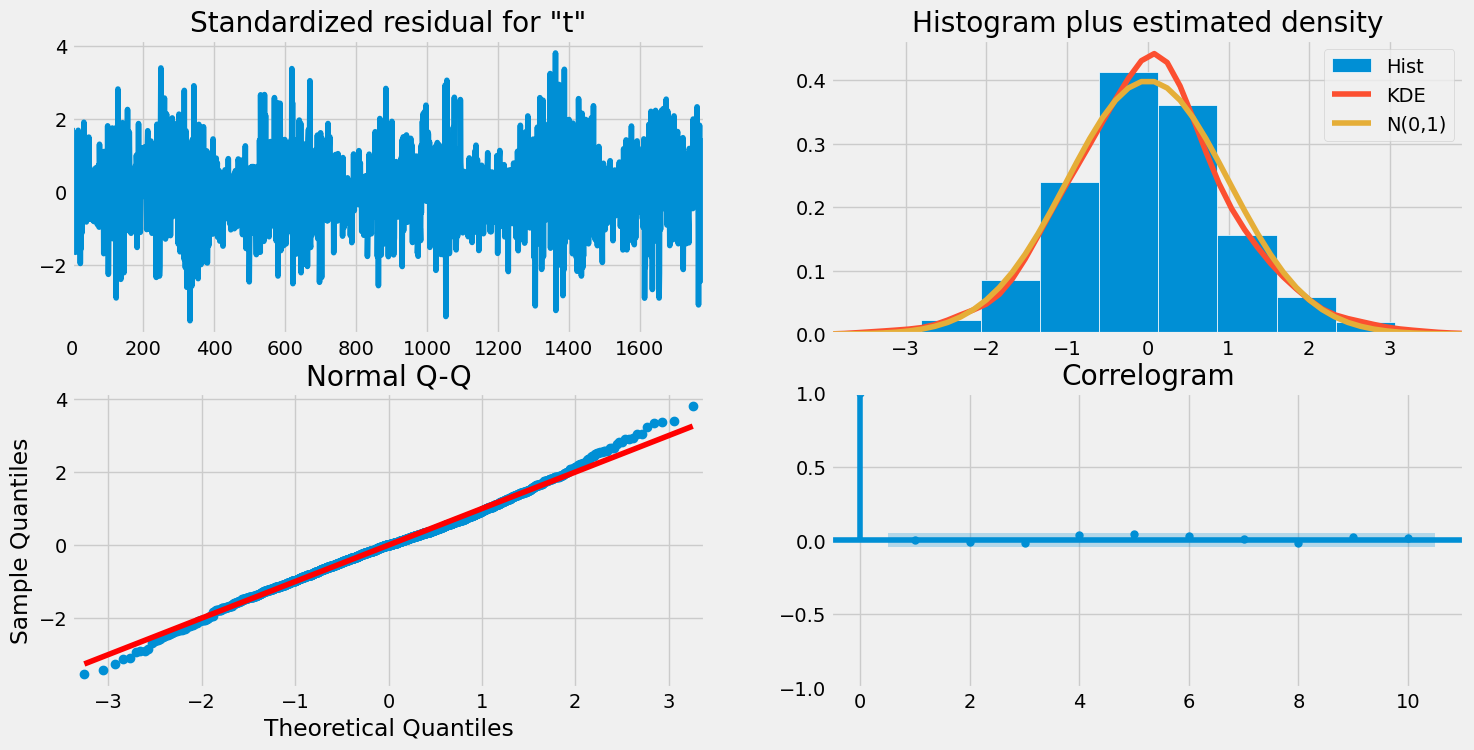

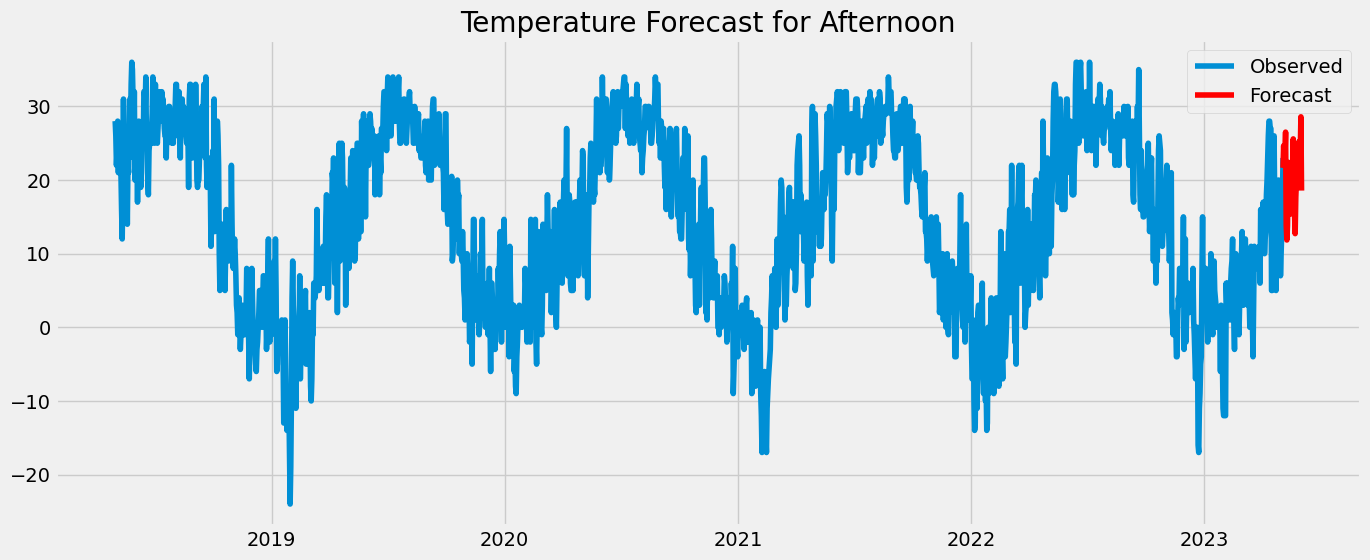

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4899      0.021     22.987      0.000       0.448       0.532
ma.L1         -0.9618      0.007   -134.719      0.000      -0.976      -0.948
ar.S.L12      -0.5222      0.019    -27.693      0.000      -0.559      -0.485
sigma2        32.9991      0.980     33.688      0.000      31.079      34.919


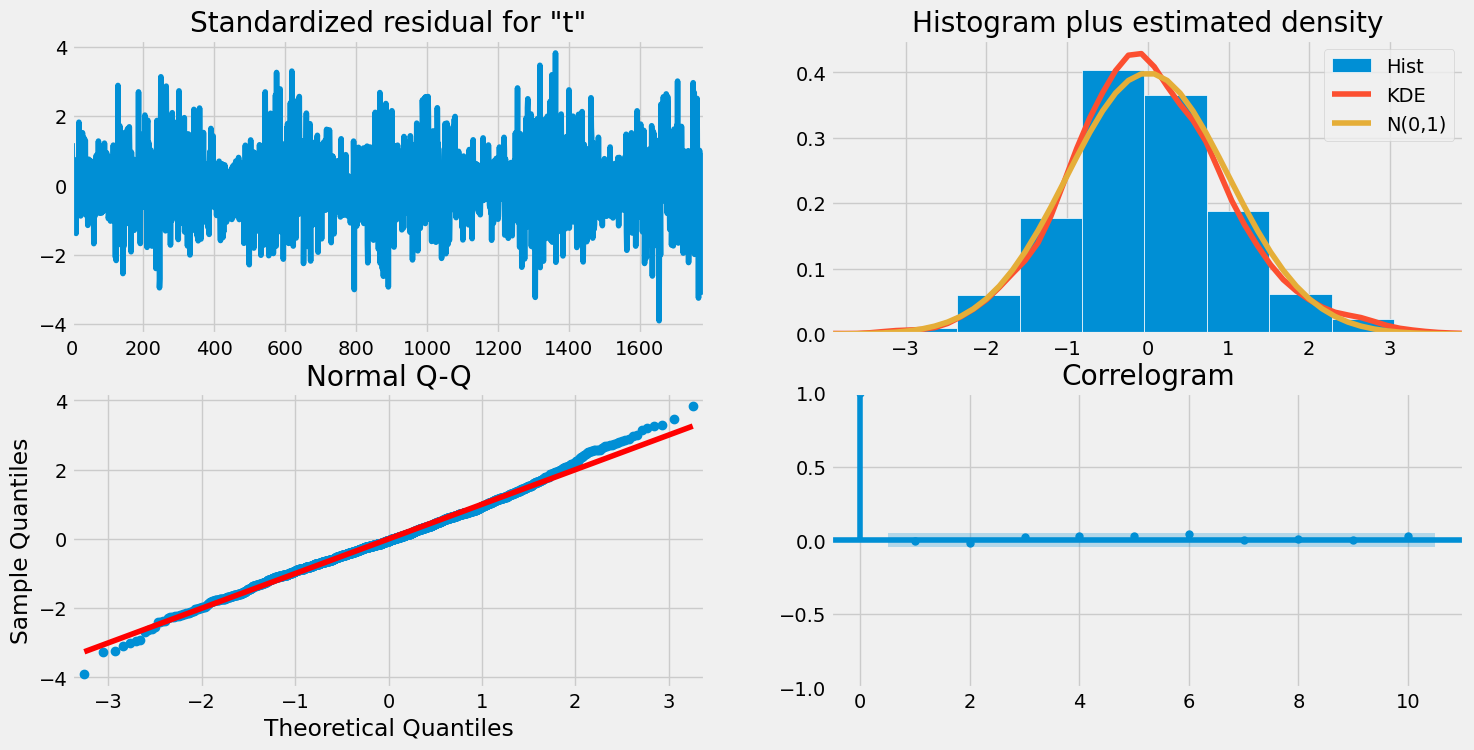

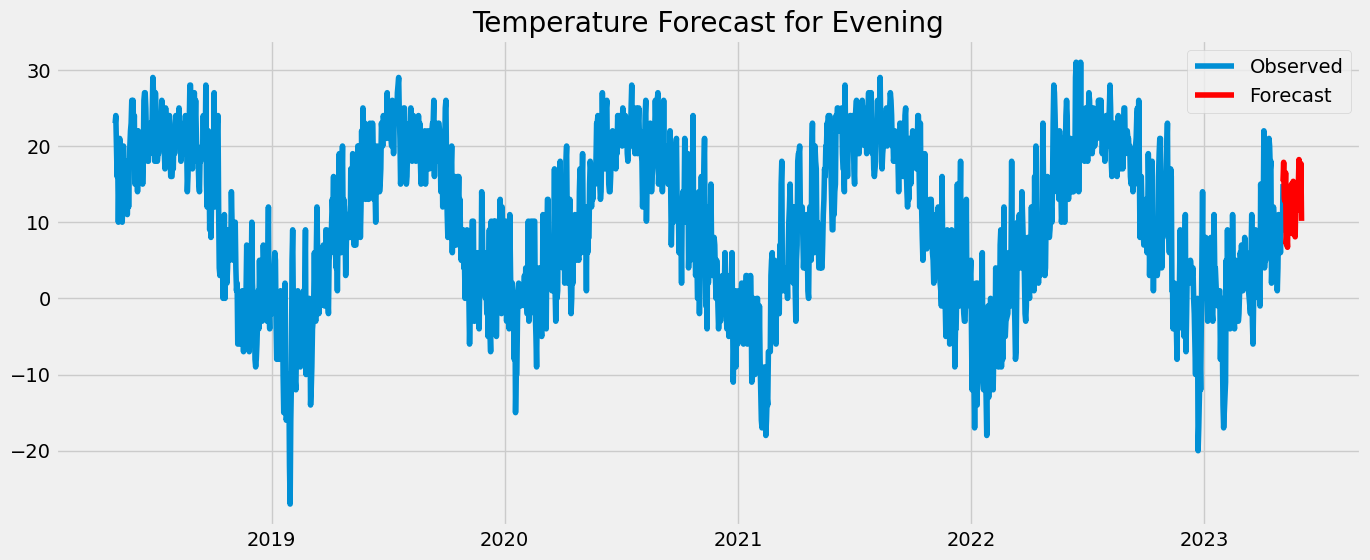

In [29]:
# Importing necessary libraries
import warnings
import ast
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

# Ignoring warnings
warnings.filterwarnings("ignore")

# Setting plot style
plt.style.use('fivethirtyeight')

# Reading data from CSV and parsing datetime columns
data = pd.read_csv('Earthcamweather_data.csv', parse_dates=['datetime', 'ObservedAt_DateTime'])

# Extracting date part from datetime
data['observed_date'] = data.ObservedAt_DateTime.dt.date

# Extracting Celsius temperature
data['temp_c'] = data['Temperature'].apply(lambda x: int(ast.literal_eval(x)['Celsius']))

# Defining time bins
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']

# Adding time bin to the dataframe
data['Time_bin'] = pd.cut(data.ObservedAt_DateTime.dt.hour, bins, labels=labels, right=False)

# Grouping data by date and time bin and calculating mean temperature
temp_data = data.groupby(['observed_date', 'Time_bin'])['temp_c'].mean().reset_index()

# Loop through time bins and perform forecasting and diagnostics
for time_bin in labels:
    # Filtering data for the specific time bin
    time_bin_data = temp_data[temp_data['Time_bin'] == time_bin].copy()
    time_bin_data.drop(columns="Time_bin", axis=1, inplace=True)

    # Filling missing temperature values with mean
    time_bin_data['temp_c'].fillna(time_bin_data['temp_c'].mean(), inplace=True)

    # Setting date as index
    time_bin_data.set_index('observed_date', inplace=True)

    # Fitting SARIMA model
    mod = sm.tsa.statespace.SARIMAX(time_bin_data,
                                    order=(1, 1, 1),
                                    seasonal_order=(1, 1, 0, 12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()

    # Printing model summary
    print(results.summary().tables[1])

    # Plotting diagnostics
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()

    # Forecasting
    forecast_dates = pd.date_range(start=time_bin_data.index[-1], periods=30, freq='D')
    forecast = results.get_forecast(steps=30)
    predicted_values = forecast.predicted_mean

    # Plotting forecast
    plt.figure(figsize=(15, 6))
    plt.plot(time_bin_data.index, time_bin_data['temp_c'], label='Observed')
    plt.plot(forecast_dates, predicted_values, label='Forecast', color='r')
    plt.title(f'Temperature Forecast for {time_bin}')
    plt.legend()
    plt.show()


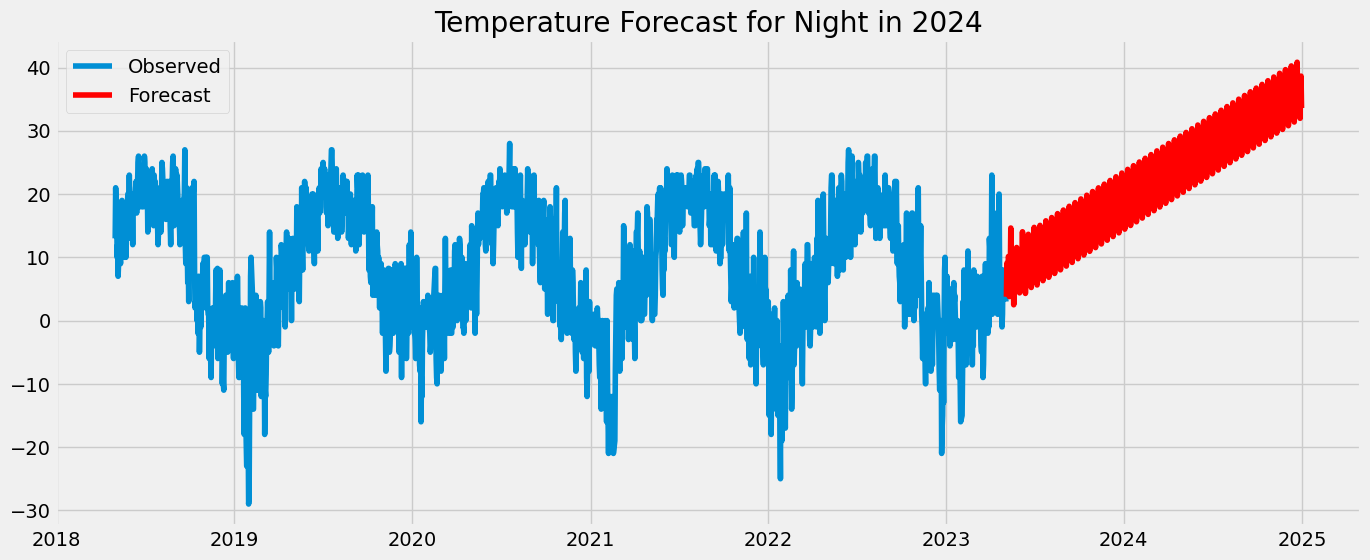

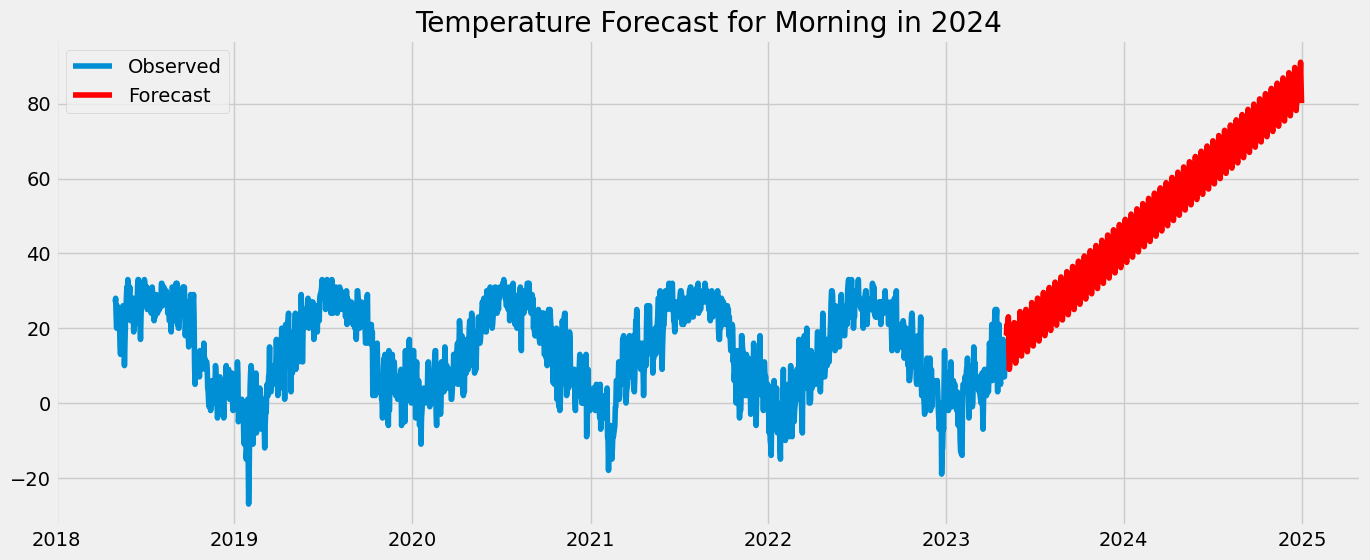

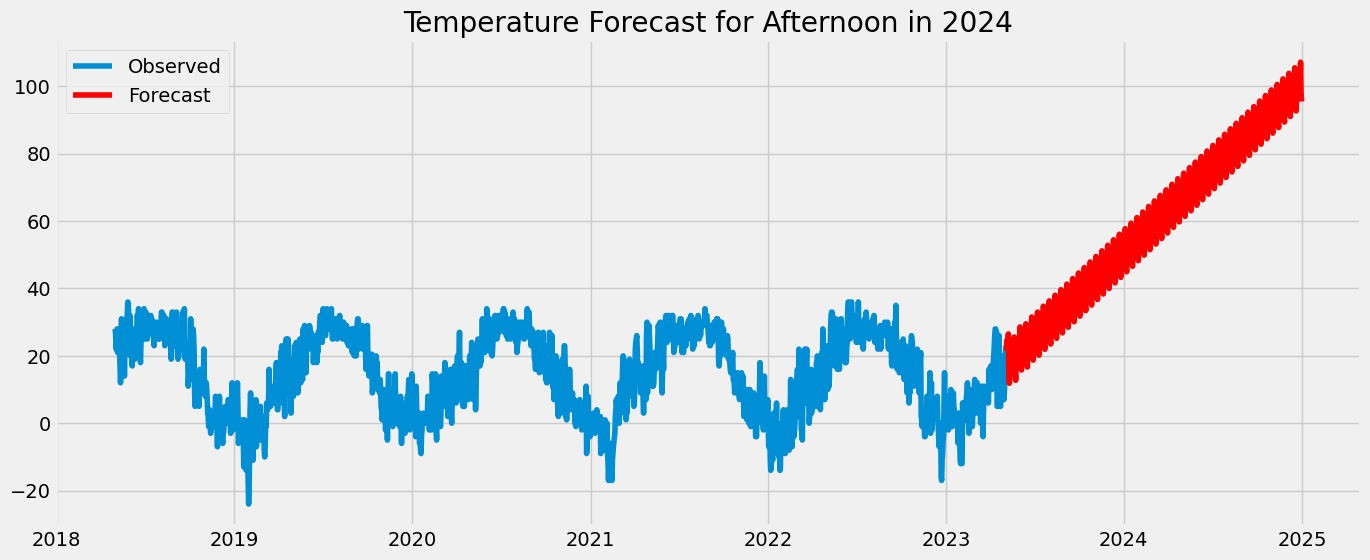

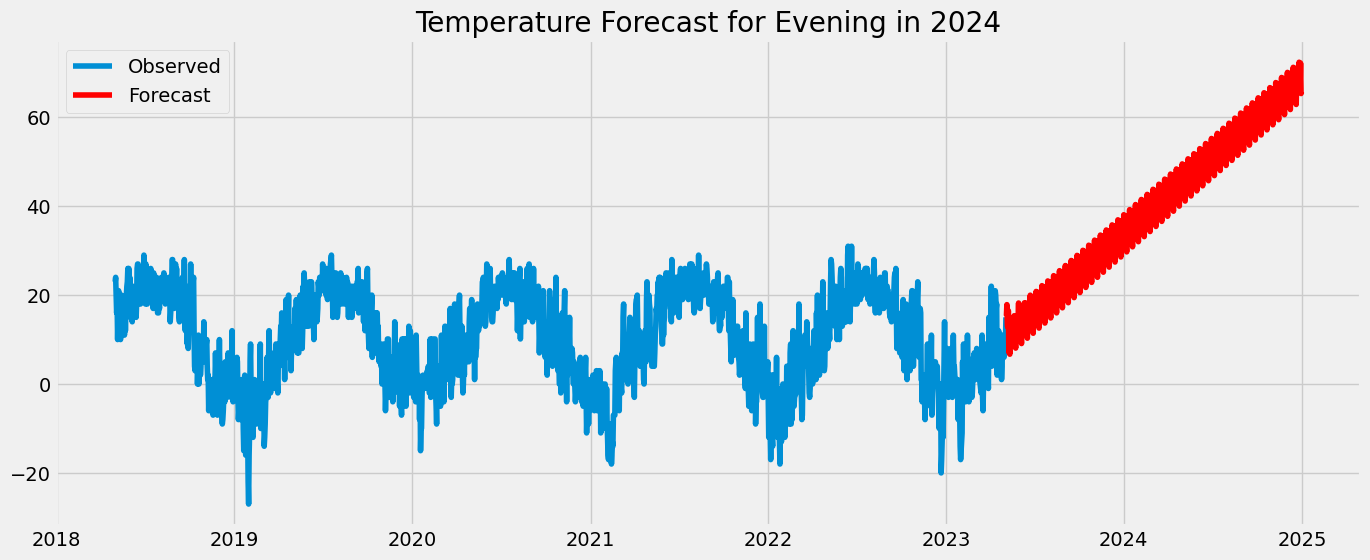

In [34]:
# Loop through time bins and perform forecasting for 2024
for time_bin in labels:
    # Filtering data for the specific time bin
    time_bin_data = temp_data[temp_data['Time_bin'] == time_bin].copy()
    time_bin_data.drop(columns="Time_bin", axis=1, inplace=True)

    # Filling missing temperature values with mean
    time_bin_data['temp_c'].fillna(time_bin_data['temp_c'].mean(), inplace=True)

    # Setting date as index
    time_bin_data.set_index('observed_date', inplace=True)

    # Fitting SARIMA model
    mod = sm.tsa.statespace.SARIMAX(time_bin_data,
                                    order=(1, 1, 1),
                                    seasonal_order=(1, 1, 0, 12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()

    # Forecasting for 2024
    forecast_start_date = pd.to_datetime('2023-05-05')
    forecast_end_date = pd.to_datetime('2024-12-31')
    forecast_dates = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='D')
    forecast = results.get_forecast(steps=len(forecast_dates))
    predicted_values = forecast.predicted_mean

    # Plotting forecast
    plt.figure(figsize=(15, 6))
    plt.plot(time_bin_data.index, time_bin_data['temp_c'], label='Observed')
    plt.plot(forecast_dates, predicted_values, label='Forecast', color='r')
    plt.title(f'Temperature Forecast for {time_bin} in 2024')
    plt.legend()
    plt.show()


In [42]:
# Specify the desired date in 2024
forecast_date = pd.to_datetime('2024-02-15')  # Replace with your desired date

# Get the index of the specified date in the forecast
forecast_index = forecast_dates.get_loc(forecast_date)

# Forecasting for the specified date
forecast = results.get_forecast(steps=forecast_index + 1)  # Include the specified date
forecasted_temperatures = forecast.predicted_mean

# Get the forecasted temperature for the specified date
forecasted_value = forecasted_temperatures.iloc[forecast_index]

# Print the forecasted temperature
print(f"Forecasted temperature for {forecast_date.date()}: {forecasted_value:.2f}°C")


Forecasted temperature for 2024-02-15: 36.84°C


In [43]:
# Specify the desired date in 2024
forecast_date = pd.to_datetime('2024-04-15')  # Replace with your desired date

# Get the index of the specified date in the forecast
forecast_index = forecast_dates.get_loc(forecast_date)

# Forecasting for the specified date
forecast = results.get_forecast(steps=forecast_index + 1)  # Include the specified date
forecasted_temperatures = forecast.predicted_mean

# Get the forecasted temperature for the specified date
forecasted_value = forecasted_temperatures.iloc[forecast_index]

# Print the forecasted temperature
print(f"Forecasted temperature for {forecast_date.date()}: {forecasted_value:.2f}°C")


Forecasted temperature for 2024-04-15: 42.56°C


In [44]:
# Specify the desired date in 2024
forecast_date = pd.to_datetime('2024-03-15')  # Replace with your desired date

# Get the index of the specified date in the forecast
forecast_index = forecast_dates.get_loc(forecast_date)

# Forecasting for the specified date
forecast = results.get_forecast(steps=forecast_index + 1)  # Include the specified date
forecasted_temperatures = forecast.predicted_mean

# Get the forecasted temperature for the specified date
forecasted_value = forecasted_temperatures.iloc[forecast_index]

# Print the forecasted temperature
print(f"Forecasted temperature for {forecast_date.date()}: {forecasted_value:.2f}°C")


Forecasted temperature for 2024-03-15: 39.86°C
